# Uber Trip Analysis using Machine Learning

This project analyzes historical Uber trip data to understand
demand patterns and build a machine learning model to predict
future trip demand.

The analysis focuses on time-based trends, feature engineering,
and exploratory data analysis to prepare data for machine learning.

## Objectives
- Clean and preprocess Uber trip dataset
- Perform Exploratory Data Analysis (EDA)
- Visualize demand trends and patterns
- Build ML models to predict trip demand
- Evaluate model performance using error metrics

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('../images/eda', exist_ok=True)
os.makedirs('../images/ml', exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Visualization Settings


In [22]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

## Load Dataset

The dataset contains daily aggregated Uber trip records including:
- `date`
- `active_vehicles`
- `trips`


In [3]:
df = pd.read_csv('../data/Uber-Jan-Feb-FOIL.csv')
df.head()


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


### Data Understanding

In [4]:
df.info()
df.shape
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


Index(['dispatching_base_number', 'date', 'active_vehicles', 'trips'], dtype='object')

## Data Cleaning & Feature Engineering

- Convert `date` column into datetime format
- Extract useful time features like weekday, month, day
- Check missing values and duplicates


In [5]:
df['date'] = pd.to_datetime(df['date'])

print("Missing values:\n", df.isnull().sum())

df.drop_duplicates(inplace=True)

df['weekday'] = df['date'].dt.weekday
df['weekday_name'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


Missing values:
 dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
dtype: int64


In [6]:
df.head()

,dispatching_base_number,date,active_vehicles,trips,weekday,weekday_name,month,day
0,B02512,2015-01-01,190,1132,3,Thursday,1,1
1,B02765,2015-01-01,225,1765,3,Thursday,1,1
2,B02764,2015-01-01,3427,29421,3,Thursday,1,1
3,B02682,2015-01-01,945,7679,3,Thursday,1,1
4,B02617,2015-01-01,1228,9537,3,Thursday,1,1


### Daily Aggregation of Trips


In [7]:
daily_trips = df.groupby(df.index).agg({
    'trips': 'sum',
    'active_vehicles': 'sum'
})

In [8]:
daily_trips.shape

(354, 2)

# Exploratory Data Analysis (EDA)

In this section we analyze:
- Daily trip demand trend
- Active vehicle trend
- Weekday demand
- Trips vs active vehicles relationship
- Correlation between key variables


### Daily Trips Trend

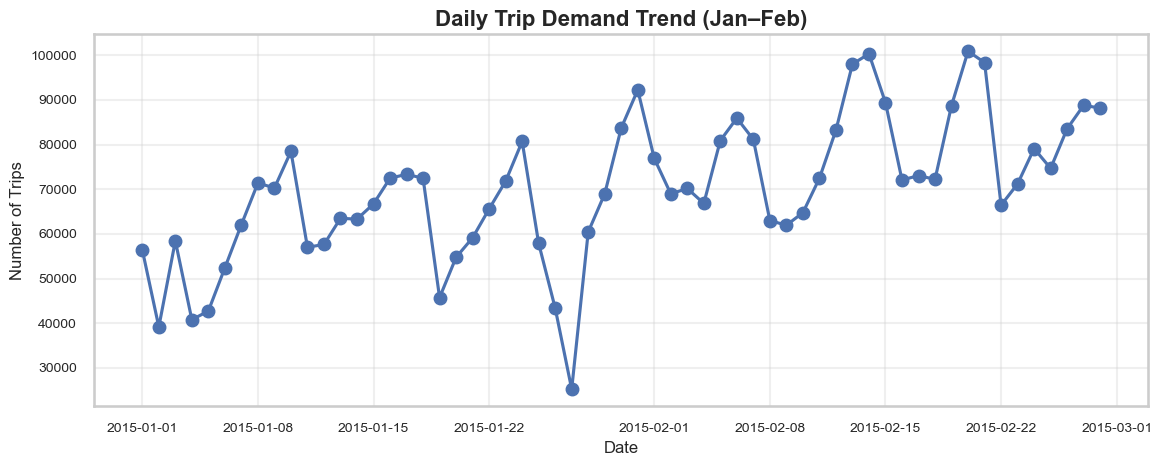

In [24]:
daily_trips = df.groupby('date')[['trips','active_vehicles']].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_trips.index, daily_trips['trips'], marker="o")
plt.title("Daily Trip Demand Trend (Jan–Feb)", weight="bold")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/eda/01_daily_trips_trend.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Trip demand fluctuates daily with visible peak days, showing strong variation in ride demand.


### Active Vehicles Trend

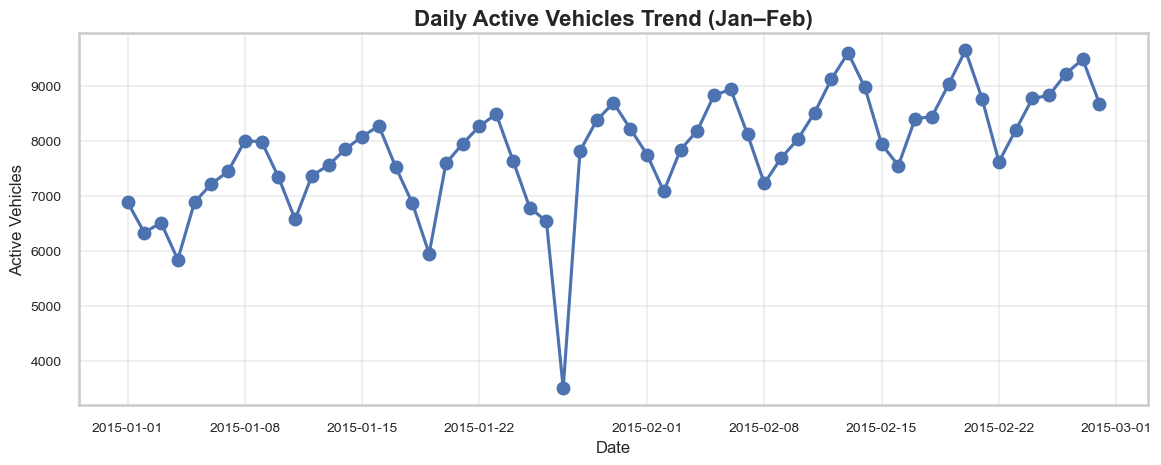

In [25]:
plt.figure(figsize=(12,5))
plt.plot(daily_trips.index, daily_trips['active_vehicles'], marker="o")
plt.title("Daily Active Vehicles Trend (Jan–Feb)", weight="bold")
plt.xlabel("Date")
plt.ylabel("Active Vehicles")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/eda/02_active_vehicles_trend.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Uber adjusts active vehicle supply over time based on demand, visible through supply variations.


### Trips vs Active Vehicles 
(Regression scatter)

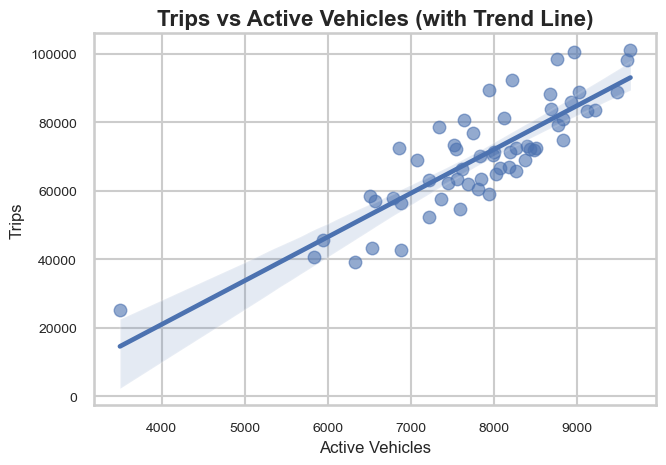

In [26]:
plt.figure(figsize=(7,5))
sns.regplot(x=daily_trips['active_vehicles'], y=daily_trips['trips'], scatter_kws={"alpha":0.6})
plt.title("Trips vs Active Vehicles (with Trend Line)", weight="bold")
plt.xlabel("Active Vehicles")
plt.ylabel("Trips")
plt.tight_layout()
plt.savefig('../images/eda/03_trips_vs_active_vehicles.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** There is a positive relationship between active vehicles and trips, meaning higher supply supports higher demand fulfillment.


### Weekday-wise Demand

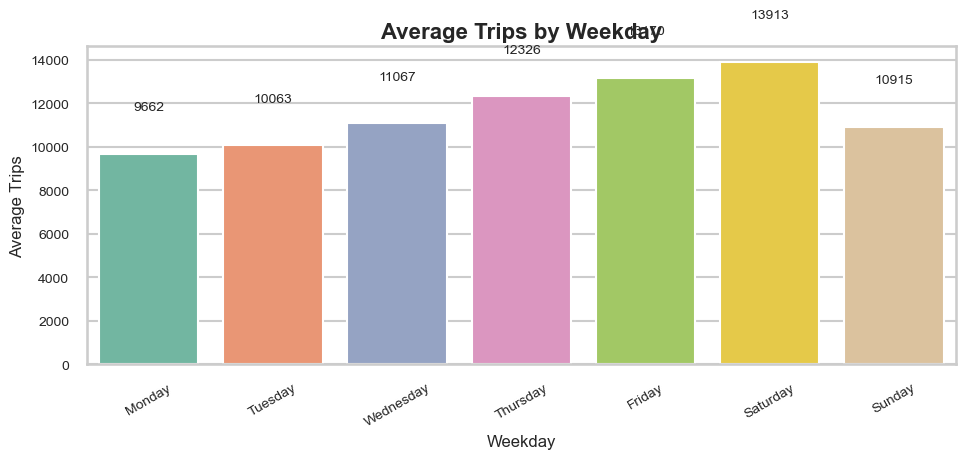

In [27]:
weekday_avg = df.groupby('weekday_name')['trips'].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    x=weekday_avg.index,
    y=weekday_avg.values,
    hue=weekday_avg.index,
    palette="Set2",
    legend=False
)

for i, v in enumerate(weekday_avg.values):
    ax.text(i, v + 2000, str(int(v)), ha="center", fontsize=10)

plt.title("Average Trips by Weekday", weight="bold")
plt.xlabel("Weekday")
plt.ylabel("Average Trips")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../images/eda/04_weekday_demand.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Weekday analysis highlights demand differences, which can help improve fleet scheduling and pricing strategy.


### Correlation Heatmap

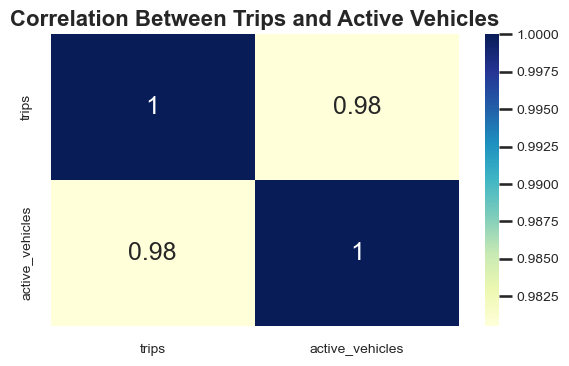

In [28]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['trips','active_vehicles']].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Between Trips and Active Vehicles", weight="bold")
plt.tight_layout()
plt.savefig('../images/eda/05_correlation_heatmap.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Strong correlation indicates demand changes generally require supply adjustments.


### Moving Average Trend

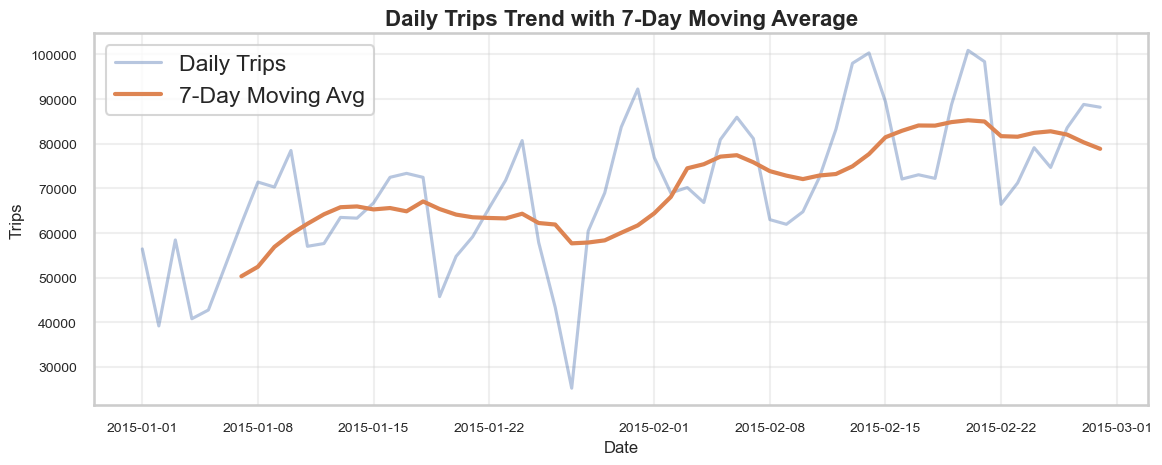

In [29]:
daily_trips['trips_7day_avg'] = daily_trips['trips'].rolling(7).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_trips.index, daily_trips['trips'], alpha=0.4, label="Daily Trips")
plt.plot(daily_trips.index, daily_trips['trips_7day_avg'], linewidth=3, label="7-Day Moving Avg")

plt.title("Daily Trips Trend with 7-Day Moving Average", weight="bold")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/eda/06_trips_moving_avg.png', dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Moving average smoothens daily fluctuations and highlights overall demand trend.


# Machine Learning

The target variable is the total number of daily trips.
Time-based and operational features are used as inputs
to predict future trip demand.

In [9]:
df = df.sort_values("date")

features = ['active_vehicles', 'weekday', 'month', 'day']
X = df[features]
y = df['trips']

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 295
Test size: 59


### Train Models

In [12]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
gb = GradientBoostingRegressor(random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)


### XGBoost Model

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

### Model Evaluation Function

In [14]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print("MAE :", round(mae, 2))
    print("RMSE:", round(rmse, 2))
    print("R²  :", round(r2, 4))
    print()

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Gradient Boosting", y_test, gb_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

--- Random Forest ---
MAE : 1046.73
RMSE: 1385.87
R²  : 0.9854

--- Gradient Boosting ---
MAE : 855.0
RMSE: 1168.8
R²  : 0.9896

--- XGBoost ---
MAE : 1097.78
RMSE: 1518.91
R²  : 0.9825



## Model Comparison

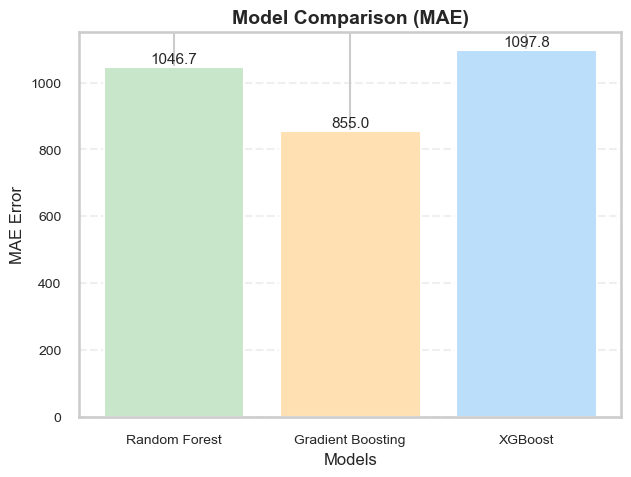

In [23]:
mae_rf = mean_absolute_error(y_test, rf_pred)
mae_gb = mean_absolute_error(y_test, gb_pred)
mae_xgb = mean_absolute_error(y_test, xgb_pred)

models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
mae_scores = [mae_rf, mae_gb, mae_xgb]

plt.figure(figsize=(7,5))
colors = ['#C8E6C9', '#FFE0B2', '#BBDEFB']

bars = plt.bar(models, mae_scores, color=colors)

plt.title("Model Comparison (MAE)", fontsize=14, weight="bold")
plt.ylabel("MAE Error", fontsize=12)
plt.xlabel("Models", fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10,
             round(yval,1), ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig("../images/ml/01_Model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Ensemble Model

In [18]:
ensemble_pred = (
    0.4 * xgb_pred +
    0.3 * rf_pred +
    0.3 * gb_pred
)

evaluate_model("Ensemble Model", y_test, ensemble_pred)

--- Ensemble Model ---
MAE : 999.38
RMSE: 1311.53
R²  : 0.9869



## Model Performance: Actual vs Predicted

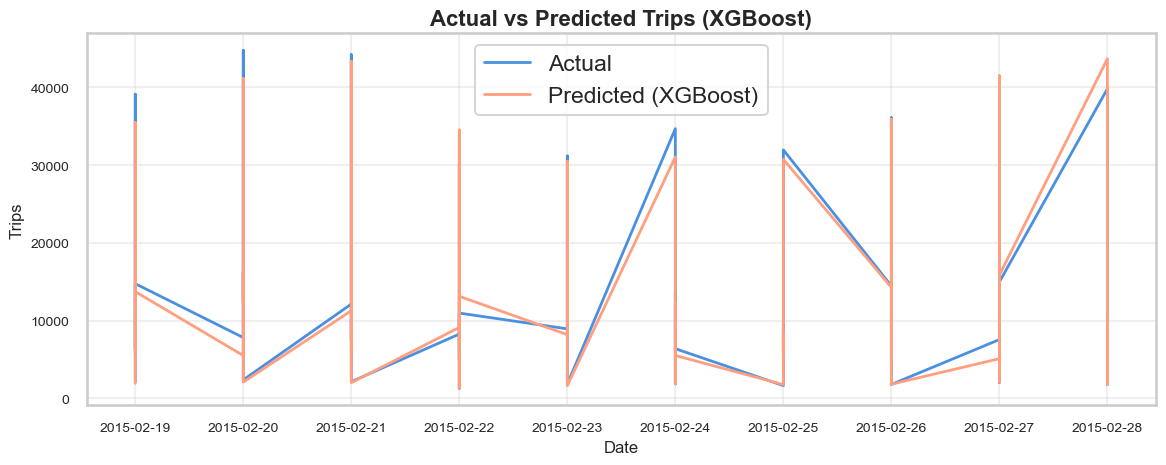

In [24]:
compare_df = pd.DataFrame({
    "date": df.loc[X_test.index, "date"],
    "actual": y_test.values,
    "predicted": xgb_pred
}).sort_values("date")

plt.figure(figsize=(12,5))

plt.plot(compare_df["date"], compare_df["actual"],
         label="Actual", linewidth=2, color="#4A90E2")  # soft blue

plt.plot(compare_df["date"], compare_df["predicted"],
         label="Predicted (XGBoost)", linewidth=2, color="#FF9F80")  # nude peach

plt.title("Actual vs Predicted Trips (XGBoost)", weight="bold")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../images/ml/02_actual_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()

**Insight:** Sorting predictions by date provides a clearer view of demand trends. The scatter plot confirms that predicted trips are close to actual values, indicating good model performance.


## Error Distribution

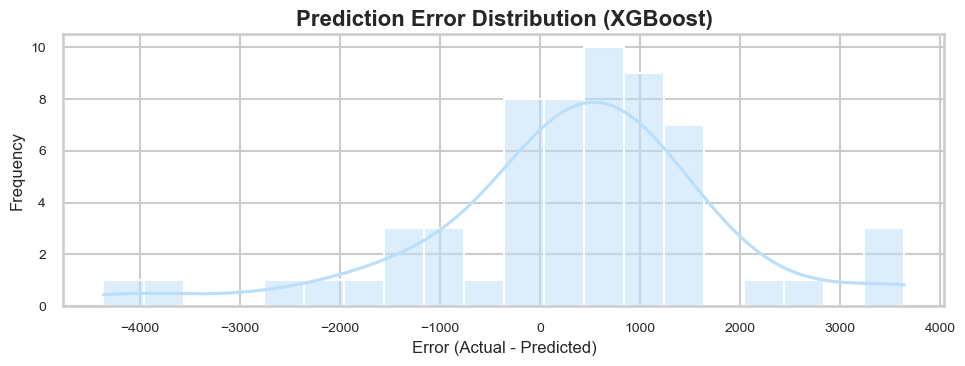

In [25]:
errors = y_test.values - xgb_pred

plt.figure(figsize=(10,4))
sns.histplot(errors, bins=20, kde=True, color="#BBDEFB")

plt.title("Prediction Error Distribution (XGBoost)", weight="bold")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("../images/ml/03_error_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

**Insight:** Error distribution indicates model stability and shows how consistently the model predicts demand.

## Challenges Faced
- Uber demand shows high volatility, making prediction challenging.
- Time-series nature of data required special validation (TimeSeriesSplit).
- Multiple ML models had to be compared to select the best performer.
- Balancing supply (active vehicles) and demand (trips) required feature engineering.

## Conclusion
- Strong weekly and monthly demand patterns were discovered through EDA.
- Multiple ML models were trained: Random Forest, Gradient Boosting and XGBoost.
- XGBoost achieved the best performance among individual models.
- Ensemble modeling improved prediction stability and reliability.
- Time-series validation made the model closer to real-world deployment.

## Future Scope
- Use full-year Uber data for long-term seasonality forecasting.
- Implement advanced time-series models (ARIMA, Prophet, LSTM).
- Deploy the model as a real-time prediction dashboard.
- Include weather and event data to improve accuracy.